# Overview

In this notebook we will cover the basic concepts for developing convolutional neural networks in Tensorflow and also introduce the data that we will be using in this tutorial from the MICCAI Brain Tumor Segmentation Challenge (BRaTS).

* Dependencies and tools
* BRATS MRI data
* TensorFlow graph structure
* Convolutions
* Activation functions
* Max-pool
* Loss functions

More information about he BRaTS Challenge can be found here: http://braintumorsegmentation.org/

# Tools

Several key dependencies and tools are required to develop deep learning algorithms. Here we discuss the rationale for these including the chosen tools used in this tutorial (and preloaded into the AWS instance) as well as alternatives that exist.

### GPU and drivers

The driving force behind recent advances in deep learning research over the past several years is the computational optimizations for parallel matrix operations afforded by graphics processing units (GPUs). The vast majority of all research and associated frameworks have been optimized for NVIDIA GPU cards, and are thus form the basis for the hardware used here.

The software interface to the underlying NVIDIA hardware is mediated through CUDA (language/API for programming on the graphics card) and cuDNN (a library for implementing neural networks using CUDA). While it is possible to build your own deep learning framework using CUDA and cuDNN, many mature community-supported deep learning frameworks built on CUDA/cuDNN already exist. 

### Deep learning frameworks

The vast majority of these deep learning libraries are designed for Python including TensorFlow, Theano, Keras (high-level API running on top of TensorFlow or Theano), Pytorch and several others. In this tutorial we will use TensorFlow, currently one of the most popularly used frameworks developed and maintained by the Google Brain team. 

While Python is the most commonly used programming language for deep learning due to its larger, more well-developed and supported ecosystem for machine learning libraries, several other alternatives exist. For example TensorFlow does support APIs for R, Java, Go and C. Matlab also has several add-ons for deep learning, as well as an open-source library in MatConvNet (http://www.vlfeat.org/matconvnet/).

### Version requirements

Given the complex interplay of software libraries, each specific version has a required set of dependenices. For example, given the NVIDIA K80 GPU card on your AWS EC2 instance and the most recent TensorFlow 1.5 library, the specific NVIDIA driver version 390 is needed along with the CUDA 9.0/cuDNN 7.0 libaries. The specific library and driver versions loaded into AWS are listed below:

* NVIDIA driver version 390
* CUDA 9.0 API
* cuDNN 7.0 libraries
* Tensorflow 1.5
* Python 3.5


# BRATS MRI data

### Helper functions

The goal of this data is to generate segmentation masks demarcating various brain tumor components from 3D MR imaging volumes. A helper module `data.py` is provided in this repository for loading the preprocessed MRI data located in the `/data/brats/npy` directory of your AWS EC2 instance. Additionally the included `utils.py` library contains several useful methods for inline visualization using `matplotlib`. Let us first import these modules here: 

In [55]:
import sys, os
sys.path.append('%s/dl_tutorial/code' % os.environ['HOME'])

import data
from utils import imshow
%matplotlib inline

The following lines of code will demonstrate how to load a single random 2D training image and label pair from the training cohort and display it with the provided `imshow()` method. Feel free to re-run the following cell repeatedly (`ctrl + Enter`) to see a series of example images from the data.

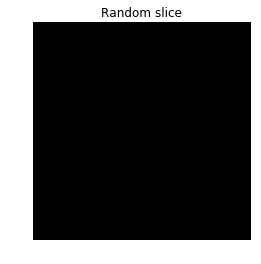

In [56]:
dat, lbl = data.load(mode='train', n=1)
imshow(dat, title='Random slice')

For the purpose of the next several lines of demonstration, we will be using a specific image and label pair (rather than randomly selected) so that all participants have identical data moving forward. Let us load that sample now:

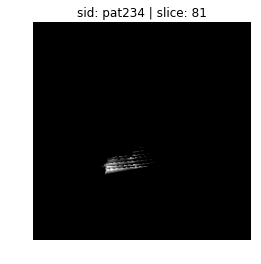

In [57]:
dat, lbl = data.load(sid='brats_tcia_pat234_0001', z=81)
imshow(dat, title='sid: pat234 | slice: 81')

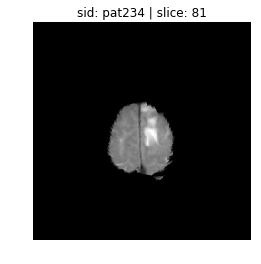

In [58]:
dat, lbl = data.load(sid='brats_tcia_pat234_0001', z=81)
imshow(dat, title='sid: pat234 | slice: 81')

### Overview of data

Let us get to know this data a little bit more. The input images in the variable `dat` are matrices of shape `1 x 240 x 240 x 4`.

In [59]:
print(dat.shape)
print(lbl.shape)
print(dat[0,...].shape)

(1, 240, 240, 4)
(1, 240, 240, 1)
(240, 240, 4)


The four channels represent four different input MRI modalities, as described below:

```
dat[..., 0] = T2
dat[..., 1] = FLAIR
dat[..., 2] = T1 precontrast
dat[..., 3] = T1 postcontrast
```

To visualize these different modalities run the following cell:

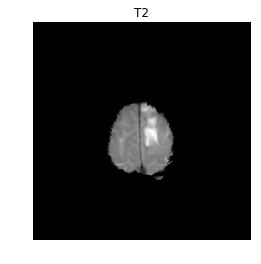

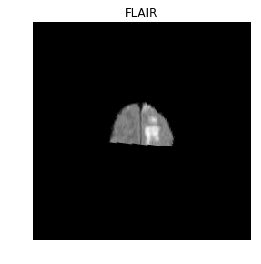

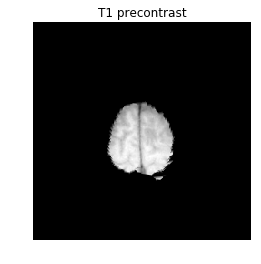

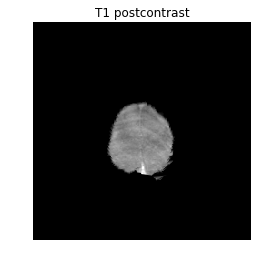

In [60]:
imshow(dat[..., 0], title='T2')
imshow(dat[..., 1], title='FLAIR')
imshow(dat[..., 2], title='T1 precontrast')
imshow(dat[..., 3], title='T1 postcontrast')

### Overview of labels

The output labels in the variable `lbl` an matrices of shape `1 x 240 x 240 x 1`. At each voxel location, there are one of 5 possible labels:

```
0 = background (no tumor)
1 = edema
2 = non-enhancing tumor 
3 = necrosis
4 = enhancing tumor
```

Let us take a look at the label now:

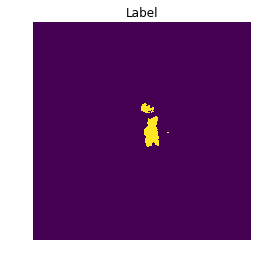

In [61]:
imshow(lbl, title='Label')

In this case, the tumor is predominantly edema (blue) and enhancing tumor (yellow). We can visualize the overlap of the data and labels by passing both matrices to the `imshow()` function:

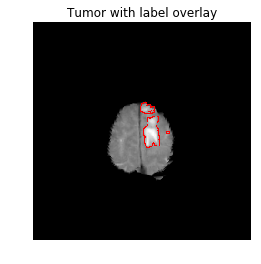

In [62]:
imshow(dat=dat, lbl=lbl, title='Tumor with label overlay')

# TensorFlow dataflow graphs

Tensorflow uses a **dataflow** graph to represent your computation in terms of the dependencies between individual operations. **Dataflow** is a common programming model for parallel computing. In a dataflow graph, the nodes represent units of computation, and the edges represent the data consumed or produced by a computation.

For example, in a TensorFlow graph, the `tf.matmul()` operation would correspond to a single node with two incoming edges (the matrices to be multiplied) and one outgoing edge (the result of the multiplication).

For further reading, see the following link: https://www.tensorflow.org/programmers_guide/graphs

### Placeholders

A tensorflow **placeholder** is an entry point for us to feed actual data values into the model. We must define this **placeholder** and all subsequent downstream operations performed on this **placeholder** before ever passing data into the model.

To define a placeholder `X` for our input data, we use the following lines of code:

In [74]:
import tensorflow as tf

X = tf.placeholder(tf.float32, [None, 240, 240, 4])

Here, the first argument `tf.float32` defines the dtype of the input data. The second argument `[None, 240, 240, 4]` defines that the input matrix shape will be `240 x 240 x 4`, with the leading `None` indicating that an arbitrary number of potential images may be stacked along the first dimension.

### Convolutions

A convolution is the process of adding each element of a matrix to its local neighbors, weighted by a **convolutional kernel**. For further reading, see the following link: http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html

To implement a convolutional operation in tensorflow, we will use the `tf.layers.conv2d()` method which simplifies access to the underlying `tf.nn.conv2d()` method. The latter allows for more disrete control of the convolutional operation, however is beyond the scope of this tutorial.

In [75]:
conv = tf.layers.conv2d(X, filters=8, kernel_size=(3, 3), padding='same')

Here, the first argument `X` is the placeholder we defined above and input into the convolution. The second argument `filters=8` defines that the output matrix has 8 channels (filter banks). The third argument `kernel_size=(3,3)` defines that the convolutional filter being applied will be of size `3 x 3`. Finally the final argument `padding='same'` defines that the image will be padded so that the output matrix shape will match the input matrix shape.

### Activation functions

Any arbitrary series of convolutions stacked upon one another can be composed into just a single underlying convolutional operation e.g. representing a single linear transformation. Instead richness of expression arising from the many convolutional layers of a CNN arise from the interposition of non-linearities or **activation functions** in alternating layers. An non-linear function can act as an activation function, however for the purposes of this tutorial we will just focus on the rectified linear unit (`ReLU`) function defined as:
```
ReLU(x) = max(x, 0)
```

The `ReLU` function is currently one of the most popular choices for modern CNN architectures. Note however that many other activation functions are possible, and come with associated advantages and disadvantages. For further reading, see the following link: https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6

To implement a `ReLU` nonlinearity, we will use the `tf.nn.relu()` method as follows:

In [76]:
relu = tf.nn.relu(conv)

Here, the first and only argument `conv` is the output of our convolutional operation above. Note that this is a parameter-less operation. The output will be a matrix of equal shape to the original `conv` matrix, will all negative values set to 0.

### Max-pool

The `pooling` operation is a form of non-linear down-sampling. Specifically max-pooling partitions the input image into a set of non-overlapping rectangles and, for each such sub-region, outputs the maximum value. It is useful to:

1. Reduce computation for upper layers
2. Provide a form of translation invariance

Note that for many modern CNN architectures, another popular alternative for down-sampling is to perform a strided convolution. This operation has the benefit of preserving flow of gradients during backpropogation however is beyond the scope of this tutorial. This technique was popularized the "All Convolutional Net" (*Springenberg et al*). For further reading, see the following link for the original paper: https://arxiv.org/pdf/1412.6806.pdf.

To implement a max-pool operation, we will use the `tf.layers.max_pooling2d()` method as follows:

In [82]:
pool = tf.layers.max_pooling2d(relu, pool_size=(4, 4), strides=(2, 2))

### Running a graph

Now that have a small (toy) graph built, let us see what is necessary to pass data through it. To begin, we will first need to create a `tf.Session` class object. Tensorflow uses the `tf.Session` class to represent a connection between the client program---typically a Python program---and the C++ runtime.

In [83]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)

Next we must randomly initialize all the parameters in our model. In our simple example graph, the only parameters will be contained in the convolutional filter kernel we used in the first operation. Nonetheless, we will use a general `tf.global_variables_initializer()` operation, which can be used to efficiently initialize all parameters in a graph.

In [84]:
init = tf.global_variables_initializer()
sess.run(init)

Now that the graph has been created and all parameters initialized, we can proceed with passing data through the graph structure. To do so, we use the `tf.sess.run()` method, which has two arguments. The first argument is a single (or a list of several) output(s) we wish to extract from the graph. The second argument is a feed `dict` that matches defined placeholder with the appropriate data to place into the graph. In the following example, we will be passing the variable (image) `dat` into the `X` placeholder and recieving the result of `pool` on the other side:

In [85]:
output = sess.run(pool, feed_dict={X: dat})

Can you guess what the `output` matrix shape will be? (Hint: we performed a `conv` with `3 x 3 x 4 x 8` convolutional kernel followed by a `relu` non-linearity followed by a `2 x 2 max-pooling` operation).

In [86]:
print(output.shape)

(1, 119, 119, 8)


Did you answer correctly? To understand what happened, the `conv` operation maps our 4-channel input into 8 different feature maps. The `relu` operation introduces non-linearity into our function however does not change the output layer size. Finally the `2 x 2 max-pool` operation downsamples by collapsing each 2x2 patch in our feature map into a single maximal value, thus decreasing the feature map size by 2 along both the height and width of the image.

Feel free to visualize these intermediate feature maps (`output[..., 0]` will contain the first feature map, `output[..., 1]` the second, etc):

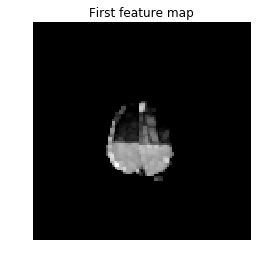

In [87]:
imshow(output[..., 0], title='First feature map')

At this point, since we've only proceed with a minimal series of three operations, each of the feature maps at this early stage will look very similar to the original image with only some slight differences.

Note that although our simple graph is a linear series of just three operations, graphs can become highly complex and non-linear in nature; as a result the output(s) that you wish to extract from the graph can be any intermediate operation at any point along your defined graph structure. Although in this example we requested the final node of our graph (`pool`) we could have replaced this argument with any others that we defined (e.g. `conv` or `relu` for example) if we wished instead to extract the output of another intermediate layer. Similarly the feed `dict` needs only to be filled with the dependent placeholders in your graph required for computing your requested output. 

### Closing a tf.session()

Finally, because each active `tf.Session` class owns physical resources (such as GPUs and network connections), it is important to explicitly call `tf.Session.close()` when you are finished with it to free the resources.

In [88]:
sess.close()

# Putting it all together

Now that we have working understanding of the basic building blocks of a neural network, let us put together a working example. Our goal will be a simple CNN classifier to determine whether or not slice contains tumor. To begin we will reset the previous tensorflow graph and start by defining the requisite placeholders.

In [89]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, 240, 240, 4], name='X')
y = tf.placeholder(tf.int32, shape=[None], name='y')
mode = tf.placeholder(tf.bool, name='mode')

In addition to the placeholder `X` for the input data, we also define two additional newplaceholders, `y` and `mode`. The placeholder `y` will serve as the method for introducing the correct target label representing presence (1) or absence (0) of tumor. The placeholder `mode` will serve as a method for introducing whether or not the graph is being executed for training or for validation. 

Now we will build a much larger graph. The `net.py` module included in this tutorial contains several simple templated architectures. Let us start by importing this as well as the Numpy library:

In [90]:
import net, numpy as np

In this example we will be using the architecture defined by `net.create_classifier()`. This classifer alternates a series of convolutions, ReLU non-linearities and max-pooling to collapse the `240 x 240 x 1` input into a single 2-channel out, one number representing likelihood of no tumor and the other representing likelihood of tumor.

A simplified diagram of the architecture is as follows:
```
DEFINITION
----------
BLOCK = [ CONV --> RELU --> CONV --> RELU --> POOL ]

LAYER NAME | OUTPUT SHAPE
------------------------------
BLOCK-01   | 120 x 120 x 8
BLOCK-02   | 060 x 060 x 16 
BLOCK-03   | 030 x 030 x 32
BLOCK-04   | 015 x 015 x 64
BLOCK-05   | 007 x 007 x 96
BLOCK-06   | 003 x 003 x 128
FLATTEN    | 001 x 001 x 1152
FC         | 001 x 001 x 2
```

Note that this diagram is simplified. This particular algorithm also implements minor additions such as batch normalization and L2 regularization which are byeond the scope of this tutorial. See source code for further information. 

To implement this architecture, simply call the `net.create_classifier()` method:

In [91]:
pred = net.create_classifier(X, training=mode)
print(pred.shape)

(?, 2)


Keep in mind from the shape output above that `pred` is a two-value arary that represents a likelihood score: the first value represents how strongly the network believes there is no tumor, the second value represents how strongly the network believes there is a tumor. Thus `pred[0] >> pred[1]` indicates a prediction of no tumor, while `pred[0] << pred[1]` indicates a prediction of tumor.

### Loss function

Next, based on these prediction logits, we need to give the algorithm feedback whether or not the network is correct. To do so, we need to define a specific function that gauges overall algorithm accuracy. Specifically we will use the softmax function, a formula that computes the exponential (e-power) of the given input value divided by the sum of exponential values of all the values in the inputs. For a classification model these values on the range of (0, 1) together represent the probability distribution of the different label classes.

To implement a softmax function, we will use the `tf.nn.sparse_softmax_cross_entropy_with_logits()` method:

In [92]:
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=pred)

### Testing the graph

Let us now run this new, expanded graph architecture. We will begin by creating the `tf.Session` object and initializing all parameters:

In [93]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

Now, let us test the network by passing pairs of data and labels into the graph and checking the reported network predictions (`pred`) and loss value (`loss`). 
Feel free to re-run the following cell repeatedly (`ctrl + Enter`) to see the network in action:

(1, 240, 240, 4)
(1, 240, 240, 1)
[0]
REAL (tumor, y/n?): n
PRED (tumor, y/n?): y
LOSS (lower value is better prediction): 2.909105


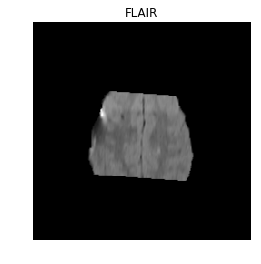

In [95]:
dat, lbl = data.load(mode='train', n=1)
print(dat.shape)
print(lbl.shape)
lbl = np.max(lbl > 0, axis=(1,2,3)).astype('int32')
print(lbl)
sce, logits = sess.run([loss, pred], {X: dat, y: lbl, mode: True})

print('REAL (tumor, y/n?): %s' % ('y' if lbl else 'n'))
print('PRED (tumor, y/n?): %s' % ('y' if logits[0, 1] > logits[0, 0] else 'n'))
print('LOSS (lower value is better prediction): %f' % sce)

imshow(dat[..., 1], title='FLAIR')

That's it, you've done it! We've created a formidible network architecture that is able to map any given `240 x 240 x 4` brain MRI slice of data into predictions regarding presence/absence of tumor. Furthermore we have a loss function that quantitatively defines how accurate the predictions are. Of course at this point, the network is simply making arbitrary guesses because it's internal parameters have just been initalized to random values. However we now have all the requisite foundation to perform *neural network training*, a process by which the algorithm on its own will learn to readjust this parameters to learn how to generate accurate predictions. This process is what we will cover in **Part 02 - Training a Classifier** of this series.

Before we leave, go ahead and close our `tf.Session` class.

In [27]:
sess.close()